# Lab 5: Acquiring and Processing our own data
Today, we will put to the test what we have learnt so far.
Once you have recorded data for each of your patients using **BioGAP**, implement a valid processing pipeline to confidently distinguish the recorded events.

As usual, import the necessary libraries

In [51]:
# Import the libraries you need here
import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple

# Custom import
from load_data import convert_raw_to_csv

## Converting the data to .csv format
**BioWolf** stores the data into a .bin file which we don't know how to handle. To simplify things we have provided you with a custom function (`convert_raw_to_csv`) that loads the raw data from the .bin files and stores it into .csv files.

Please have a look at the function to understand the inputs.

In [52]:
folder_path = f"data/"
time_scale = 's'
voltage_scale = 'uV'
save_path = 'csv/'

convert_raw_to_csv(folder_path, time_scale, voltage_scale, save_path)

File:  data/kim.bin
Sample Rate:  500.0
Signal Gain:  12.0
Voltage Scale Factor:  1000000.0
Time Scale Factor:  1
Gain Scaling:  1.1908944212550836e-08
File:  data/leo.bin
Sample Rate:  500.0
Signal Gain:  12.0
Voltage Scale Factor:  1000000.0
Time Scale Factor:  1
Gain Scaling:  1.1908944212550836e-08


## Import the data from the .csv files

If everything went well you should have created a new folder containing the .csv files with your raw data for each of your recordings. Open one of those files to inspect the data.

Now we need to load this data into our workspace. There are several ways to do this, most commonly using the popular **pandas** (`pandas`) library. For the sake of time we recommend you using a method of the **numpy** (`numpy`) library. 

In [53]:
# Hint: use np.genfromtxt
k_data = np.genfromtxt("csv/kim.csv", delimiter=',')
l_data = np.genfromtxt("csv/leo.csv", delimiter=',')

Inspect your resulting array, do you understand what is contains? If you do not, please ask a TA.

## Implement your own pipeline

There are several ways to go about this, we don't specify which one you need to go. Simply remember the end goal and think of the steps you need to take to get there. Have fun!

In [54]:

def extract_trigger_points(x) -> np.array:
    diff_array = np.diff(x[:, 8])
    return np.nonzero(diff_array)[0]

# diff_aray = np.diff(data[:,8])
# trigger_points = np.nonzero(diff_aray)[0]

k_trigger_points = extract_trigger_points(k_data)
l_trigger_points = extract_trigger_points(l_data)

# debugging
print(l_trigger_points)
print(l_data[:,8][l_trigger_points[1]]) # label at first trigger (we both have zero at first trigger, I checked again)
l_data[l_trigger_points[1]] # channels and label at first trigger

[     0 103694 114064 123855 133652 144161 154030 164107]
0.0


array([25950.16106847, 30526.60160413, 30196.83102995, 42468.49786532,
       36265.59327383, 28036.97727178, 35095.33705289, 21984.24446681,
           0.        ])

In [88]:

def create_data_array(data: np.array, trigger_points: np.array) -> Tuple[np.array, np.array]:

    X0 = np.array([])
    X1 = np.array([])  

    # started with eyes open
    for i in range(1,6,2):
        X1 = np.append(X1, data[trigger_points[i] + 2000 : trigger_points[i] + 7000, 4])

    for i in range(2,7,2):
        X0 = np.append(X0, data[trigger_points[i] + 2000 : trigger_points[i] + 7000, 4])

    return X0, X1

def create_average_data_array(data: np.array, trigger_points: np.array) -> Tuple[np.array, np.array]:

    X0_channel_stack = np.zeros((8, 15000))
    X1_channel_stack = np.zeros((8, 15000))

    for n in range(8):
        
        X0 = np.array([])
        X1 = np.array([])
        
        for i in range(2,7,2):
            X0 = np.append(X0, data[trigger_points[i] + 2000 : trigger_points[i] + 7000, n])
        
        for i in range(1,6,2):
            X1 = np.append(X1, data[trigger_points[i] + 2000 : trigger_points[i] + 7000, n])

        X0_channel_stack[n, :] = X0
        X1_channel_stack[n, :] = X1

    X0_mean = np.mean(X0_channel_stack, axis = 0)
    X1_mean = np.mean(X1_channel_stack, axis = 0)

    return X0_mean, X1_mean


k_X0, k_X1 = create_data_array(k_data, k_trigger_points)
l_X0, l_X1 = create_data_array(l_data, l_trigger_points)

k_average_X0, k_average_X1 = create_average_data_array(k_data, k_trigger_points)
l_average_X0, l_average_X1 = create_average_data_array(l_data, l_trigger_points)

# debuging
print(l_X0.shape)
print(l_X0)
print(l_average_X0.shape)
print(l_average_X0)

print(l_average_X1.shape)


(15000,)
[36090.80569962 36084.91077224 36079.37311318 ... 35709.51703277
 35710.67220036 35712.16081838]
(15000,)
[30944.90475822 30941.31421154 30939.25396419 ... 29830.43598645
 29830.28563603 29828.79255215]
(15000,)


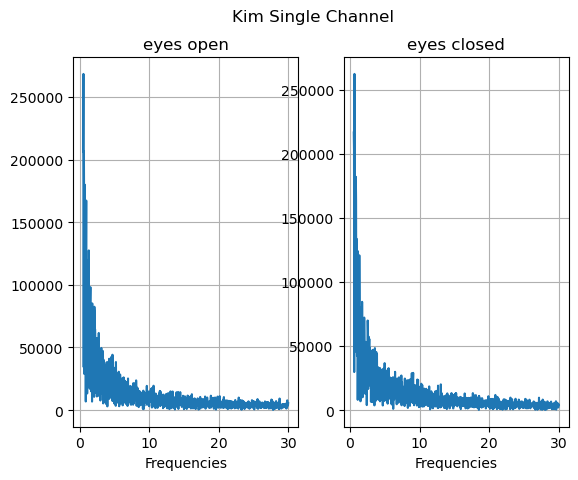

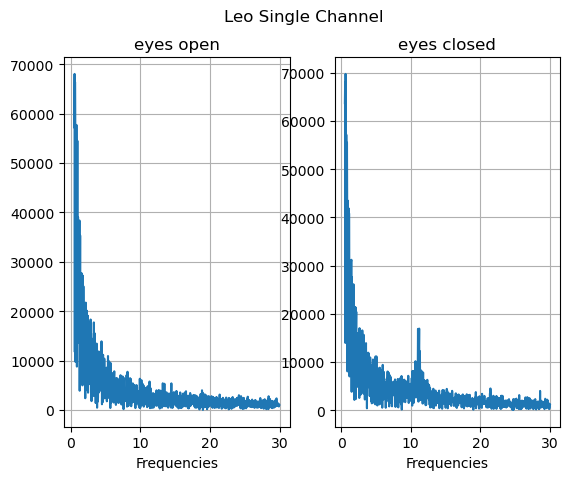

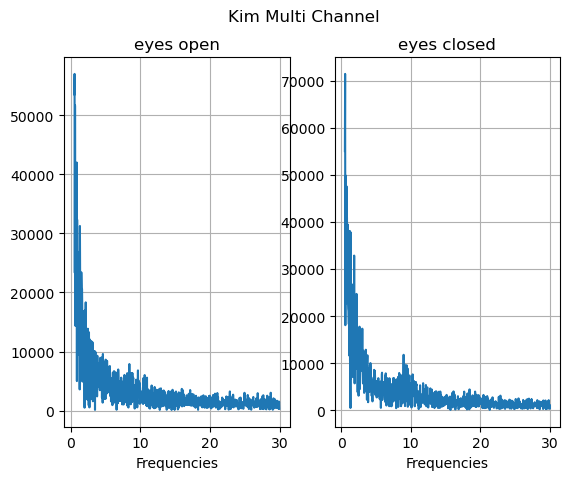

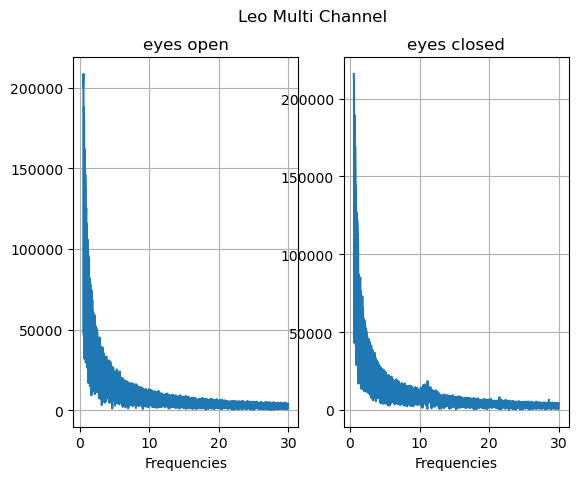

In [90]:
fft_freq = np.fft.rfftfreq(l_X0.size, 1 / 500) # our datasizes are the same
max_freq = np.where((fft_freq <= 30))[0][-1]
min_freq = np.where((fft_freq > 0.5))[0][0]

def prepare_features_FFT(x):
    return np.abs(np.fft.rfft(x)[min_freq:max_freq])

def plot(X0, X1, name):
    
    open_fft = prepare_features_FFT(X1)
    closed_fft = prepare_features_FFT(X0)
 
    y_label = fft_freq[min_freq:max_freq]

    # eyes open
    plt.subplot(1, 2, 1)
    plt.plot(y_label, open_fft)
    plt.xlabel("Frequencies")
    plt.ylabel("")
    plt.grid(True)
    plt.title("eyes open")

    # eyes closed
    plt.subplot(1, 2, 2)
    plt.plot(y_label, closed_fft)
    plt.xlabel("Frequencies")
    plt.ylabel("")
    plt.grid(True)
    plt.title("eyes closed")

    
    plt.suptitle(f"{name}")
    plt.show()


plot(k_X0, k_X1, "Kim Single Channel")
plot(l_X0, l_X1, "Leo Single Channel")

plot(k_average_X0, k_average_X1, "Kim Multi Channel")
plot(l_average_X0, l_average_X1, "Leo Multi Channel")